In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
import plotly.io as pio
from iso3166 import countries

# Ensure plots show up in the notebook
%matplotlib inline
pio.renderers.default = "notebook_connected" 

# Load data
df = pd.read_csv("space_missions.csv", encoding="latin1")
print(f"Dataset loaded: {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Dataset loaded: 4630 rows and 9 columns.


,Company,Location,Date,Time,Rocket,Mission,RocketStatus,Price,MissionStatus
0,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",1957-10-04,19:28:00,Sputnik 8K71PS,Sputnik-1,Retired,NaN,Success
1,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",1957-11-03,02:30:00,Sputnik 8K71PS,Sputnik-2,Retired,NaN,Success
2,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1957-12-06,16:44:00,Vanguard,Vanguard TV3,Retired,NaN,Failure
3,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA",1958-02-01,03:48:00,Juno I,Explorer 1,Retired,NaN,Success
4,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1958-02-05,07:33:00,Vanguard,Vanguard TV3BU,Retired,NaN,Failure


In [2]:

# remove commas, convert to float, keep NaNs as they are 
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# 3. Clean Date and extract Year
df['Time'] = df['Time'].fillna('00:00:00')
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Year'] = df['DateTime'].dt.year

# 4. Extract and Standardize Country
country_dict = {
    'Russia': 'Russian Federation',
    'New Mexico': 'USA',
    'Yellow Sea':'China',
    'Shahrud Missile Test Site': 'Iran',
    'Pacific Missile Range Facility': 'USA',
    'Barents Sea': 'Russian Federation',
    'Gran Canaria': 'USA'
}
df['Country'] = df['Location'].str.split(', ').str[-1].replace(country_dict)

# 5. Add Alpha-3 codes for the World Map
iso_map = {c.name: c.alpha3 for c in countries}
df['alpha3'] = df['Country'].replace(iso_map)
df.loc[df["Country"] == "North Korea", "alpha3"] = "PRK"
df.loc[df["Country"] == "South Korea", "alpha3"] = "KOR"

print("Cleaning complete. Price is now float64.")
df.info()

Cleaning complete. Price is now float64.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630 entries, 0 to 4629
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Company        4630 non-null   object        
 1   Location       4630 non-null   object        
 2   Date           4630 non-null   object        
 3   Time           4630 non-null   object        
 4   Rocket         4630 non-null   object        
 5   Mission        4630 non-null   object        
 6   RocketStatus   4630 non-null   object        
 7   Price          1265 non-null   float64       
 8   MissionStatus  4630 non-null   object        
 9   DateTime       4630 non-null   datetime64[ns]
 10  Year           4630 non-null   int32         
 11  Country        4630 non-null   object        
 12  alpha3         4630 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(10)
memory usage: 452.3+ KB


In [3]:
ds = df["Company"].value_counts().reset_index()[:25]
ds
fig = px.bar(ds, x="Company", y="count", title="Top 25 Companies by Launch Count", color_discrete_sequence=['#1f77b4'])
fig.show()

In [4]:
ds_rocket = df["RocketStatus"].value_counts().reset_index()
fig1 = px.pie(ds_rocket, values="count", names="RocketStatus", title="Rocket Status: Active vs Retired", hole=0.3)
fig1.show()

In [5]:
# Mission Status Bar Chart
ds_mission = df["MissionStatus"].value_counts().reset_index()[:3]
ds_mission

,MissionStatus,count
0,Success,4162
1,Failure,357
2,Partial Failure,107


In [6]:
fig2 = px.bar(ds_mission, x="MissionStatus", y="count", title="Mission Outcome Overview", color="MissionStatus")
fig2.show()

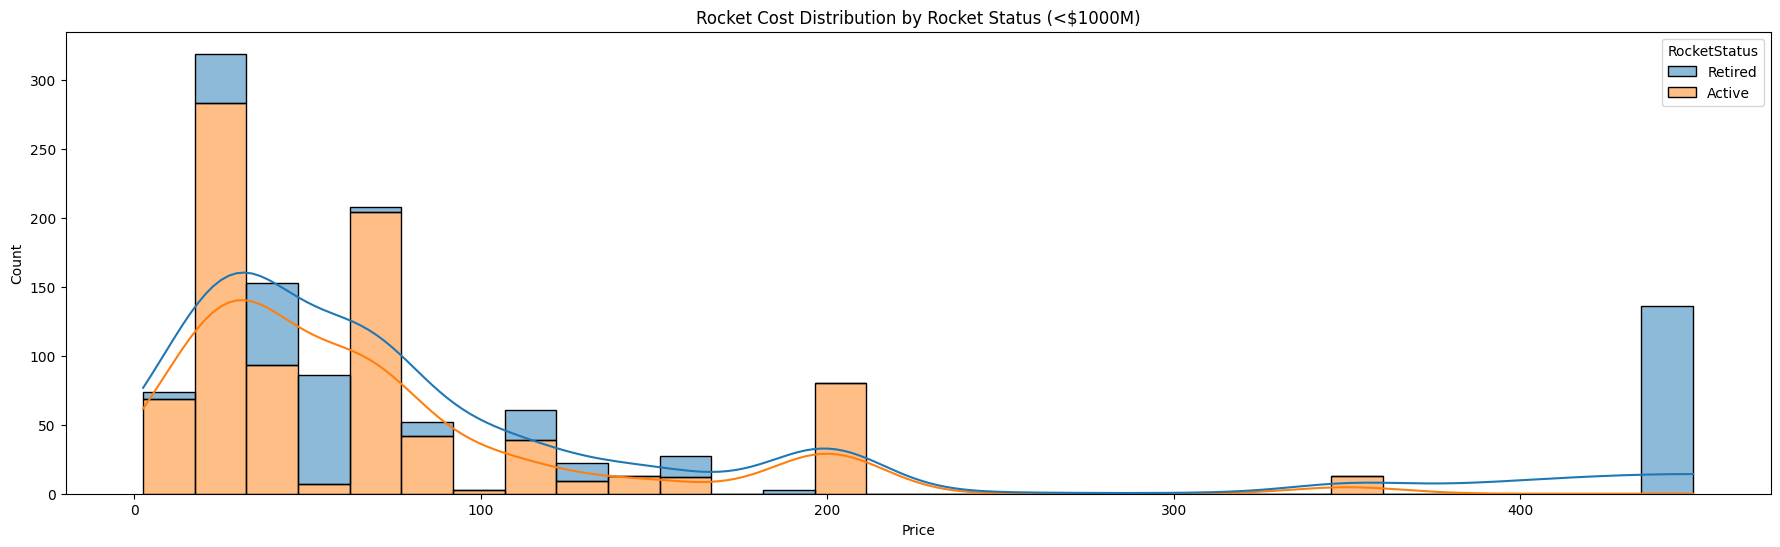

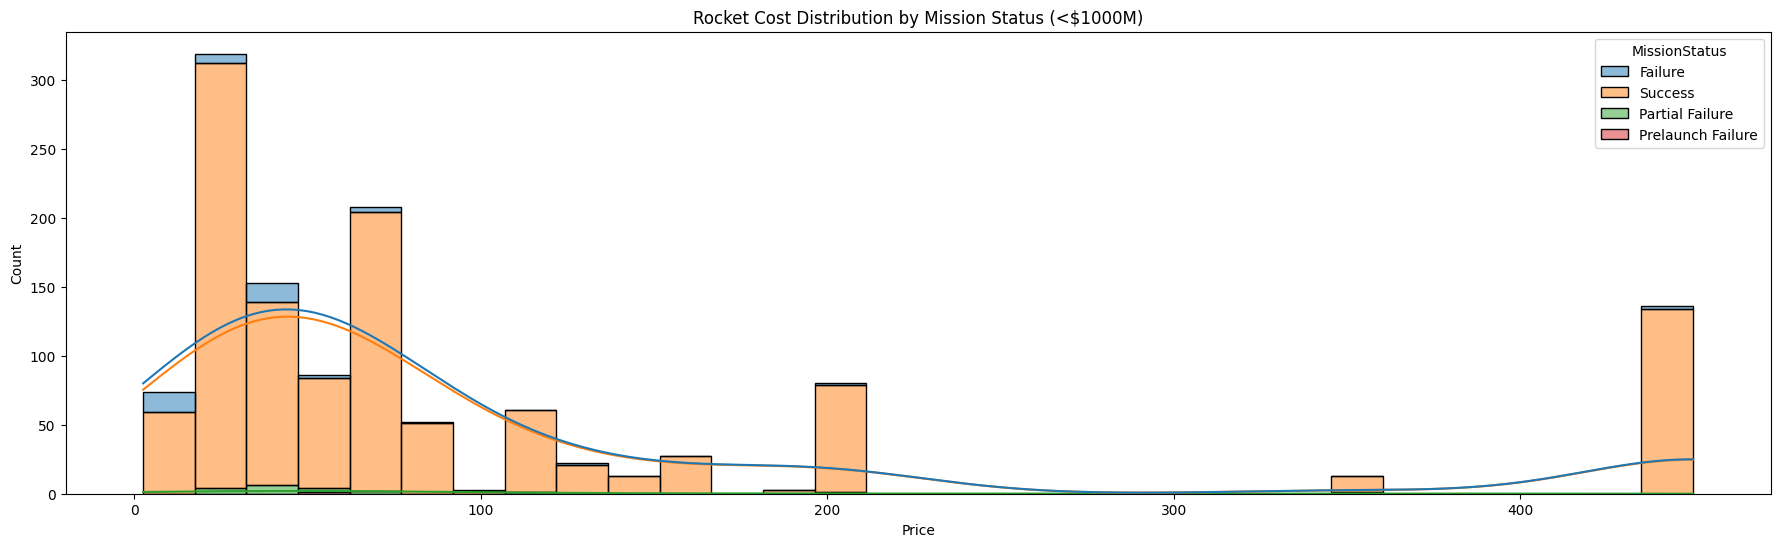

In [10]:
df_price = df[df['Price'] > 0]

plt.figure(figsize=(22, 6))
sns.histplot(data=df_price[df_price['Price'] < 1000], x="Price", hue="RocketStatus", multiple="stack", kde=True)
plt.title("Rocket Cost Distribution by Rocket Status (<$1000M)")
plt.show()

plt.figure(figsize=(22, 6))
sns.histplot(data=df_price[df_price['Price'] < 1000], x="Price", hue="MissionStatus", multiple="stack", kde=True)
plt.title("Rocket Cost Distribution by Mission Status (<$1000M)")
plt.show()

In [7]:
# Total Spent per Company (Top 15)
df_money = df.groupby("Company")["Price"].sum().reset_index().sort_values(by="Price", ascending=False)[:15]
fig3 = px.bar(df_money, x="Company", y="Price", title="Total Money Spent by Company (Millions USD)", color_discrete_sequence=['#1f77b4'])
fig3.show()

# Mission Numbers by Year
ds_year = df["Year"].value_counts().reset_index().sort_values("Year")
fig4 = px.line(ds_year, x="Year", y="count", title="Number of Space Missions per Year", markers=True)
fig4.show()

In [8]:
# Sunburst Chart for Major Players
major_countries = ["USA", "China", "Russian Federation", "France", "India"]
sun_data = df[df['Country'].isin(major_countries)]
sun_data = sun_data.groupby(["Country", "Company", "MissionStatus"]).size().reset_index(name="Count")

fig5 = px.sunburst(sun_data, path=["Country", "Company", "MissionStatus"], values="Count",
                  title="Mission Hierarchy: Country -> Company -> Status")
fig5.show()

# Status Mission by Countries in World Map
map_data = df.groupby(["Country", "alpha3"]).size().reset_index(name="MissionCount")
fig6 = px.choropleth(map_data, locations="alpha3", hover_name="Country", color="MissionCount",
                    title="Global Space Launch Activity", color_continuous_scale="Viridis")
fig6.show()

In [10]:
import os

# 1. Create a directory to keep things organized
output_dir = "space_mission_reports"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 2. SAVE MATPLOTLIB / SEABORN PLOTS
# This saves the CURRENT active plot window to a PNG
plt.figure(figsize=(22, 6)) # Re-run your specific distribution plot cell before this if needed
plt.savefig(f"{output_dir}/cost_distribution_analysis.png", dpi=300, bbox_inches='tight')

# 3. SAVE PLOTLY FIGURES
fig2.write_html(f"{output_dir}/rocket_status_pie.html")
fig3.write_html(f"{output_dir}/mission_status_bar.html")
fig4.write_html(f"{output_dir}/total_spent_money.html")
fig5.write_html(f"{output_dir}/yearly_mission_trends.html")


# 4. SAVE THE CLEANED DATA (The source for SQL & Power BI)
df.to_csv(f"{output_dir}/space_missions_cleaned.csv", index=False)

print(f"✅ Success! All plots and the cleaned CSV are saved in the '{output_dir}' folder.")

✅ Success! All plots and the cleaned CSV are saved in the 'space_mission_reports' folder.


<Figure size 2200x600 with 0 Axes>

In [14]:
fig6.write_html(f"{output_dir}/gloabl_launch_activity.html")
print("Success!")

Success!
